In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda:0')

# Logistic Regression

 Load sample dataset from sklearn dataset for classification problem

In [5]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

train_data = MNIST(
    root='mnist/',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(
    dataset=train_data,
    shuffle=True,
    batch_size=batch_size
)
train_data.data.to(torch.device(device))  # put data into GPU entirely
train_data.train_labels.to(torch.device(device))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw



tensor([5, 0, 4,  ..., 5, 6, 8], device='cuda:0')

In [6]:
test_data = MNIST(
    root='mnist/',
    train=False,
    download=True,
    transform=transform
)
test_loader = DataLoader(
    dataset=test_data,
    shuffle=True,
    batch_size=batch_size
)
test_data.data.to(torch.device(device))  # put data into GPU entirely
test_data.test_labels.to(torch.device(device))

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')

In [7]:
import matplotlib.pyplot as plt

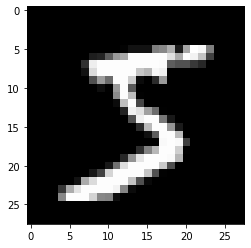

In [8]:
plt.imshow(train_data[0][0][0], cmap='gray')

In [9]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0, std=1)
           )

# Creating training and validation data for better model

In [10]:
train, val = train_test_split(train_data, test_size=0.3, random_state=42)

In [11]:
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True, num_workers = 2)

In [12]:
val_loader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True, num_workers = 2)

In [13]:
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers = 2)

# Creating a Logistic Regression Model using pytorch inbuilt functions

In [14]:
import torch.nn as nn

In [15]:
input_size = 28*28
classes = 10

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step( images, labels) for  images, labels in val_loader]
    return model.validation_epoch_end(outputs)

In [18]:
class mnist_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, classes)
    def forward(self, x):
        x = x.reshape(-1,784)
        out = self.linear(x)
        return out
    
    def training_step(self, images, labels):
        images = images.cuda()
        labels = labels.cuda()
        out = self(images)                  # Generate predictions
        loss = nn.functional.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self,  images, labels):
        images = images.cuda()
        labels = labels.cuda()
        out = self(images)                    # Generate predictions
        loss = nn.functional.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [19]:
model = mnist_model()

In [20]:
model = model.cuda()

In [21]:
cross_entropy = nn.functional.cross_entropy

In [22]:
opt = torch.optim.Adam(model.parameters(), 1e-3)

In [23]:
opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [25]:
def fit(model, loss_fn, opt, train_loader, epochs):
    history = []
    for epoch in range(epochs):
        # Iterate through training dataloader
        for  images, labels in train_loader:
            loss = model.training_step(images, labels)
            loss.backward()

            opt.step()
            opt.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    return model, history

In [25]:
model, history = fit(model, cross_entropy, opt, train_loader, 1000)

Epoch [0], val_loss: 0.3793, val_acc: 0.9003
Epoch [1], val_loss: 0.3241, val_acc: 0.9130
Epoch [2], val_loss: 0.3024, val_acc: 0.9179
Epoch [3], val_loss: 0.2930, val_acc: 0.9204
Epoch [4], val_loss: 0.2878, val_acc: 0.9214
Epoch [5], val_loss: 0.2855, val_acc: 0.9206
Epoch [6], val_loss: 0.2796, val_acc: 0.9239
Epoch [7], val_loss: 0.2782, val_acc: 0.9238
Epoch [8], val_loss: 0.2772, val_acc: 0.9244



KeyboardInterrupt



# With Easier Pytorch Lightning code

In [26]:
import os

import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("mnist", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 16 if AVAIL_GPUS else 8

In [27]:
class LitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Linear(channels * width * height, self.num_classes)

        self.accuracy = Accuracy()

    def forward(self, x):
        x = x.reshape(-1,784)
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [48000, 12000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE, num_workers=1)

In [28]:
model = LitMNIST()
trainer = Trainer(
    accelerator="gpu", devices=1,
    gpus=AVAIL_GPUS,
    max_epochs=3,
    progress_bar_refresh_rate=20,
)
trainer.fit(model)

E:\kaggle\nlp-tutorial\nlp\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | model    | Linear   | 7.9 K 
1 | accuracy | Accuracy | 0     
--------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [29]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9186000227928162     │
│         val_loss          │    0.2810959815979004     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2810959815979004, 'val_acc': 0.9186000227928162}]

In [32]:
trainer.test(model, dataloaders=model.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9186000227928162     │
│         val_loss          │    0.2810959815979004     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2810959815979004, 'val_acc': 0.9186000227928162}]

In [34]:
trainer.test(model, dataloaders=model.train_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9202291369438171     │
│         val_loss          │    0.2805672883987427     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2805672883987427, 'val_acc': 0.9202291369438171}]

In [33]:
trainer.test(model, dataloaders=model.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9125000238418579     │
│         val_loss          │    0.2994411587715149     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2994411587715149, 'val_acc': 0.9125000238418579}]